# Fairness Analysis - Gender-Based Metrics Comparison

This notebook analyzes fairness metrics between male and female users in the recommendation system.

**Key Metrics Analyzed:**
- Service performance by gender (success rates, error rates)
- Recommendation conversion rates by gender
- Rating patterns and preferences by gender
- Personalization scores by gender
- Fairness metrics (Statistical Parity, Disparate Impact, etc.)

**Data Source**: S3 events + User demographics API

**Note**: Uses 0.5% random sampling for fast analysis. Adjust `SAMPLE_FRACTION` in config to change.

## 1. Setup and Configuration

In [ ]:
# AWS credentials setup
import os
os.environ["AWS_ACCESS_KEY_ID"] = "AWS_ACCESS_KEY_ID"
os.environ["AWS_SECRET_ACCESS_KEY"] = "AWS_SECRET_ACCESS_KEY"
os.environ["AWS_DEFAULT_REGION"] = "AWS_DEFAULT_REGION"

In [2]:
# Initialize Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("fairness_analysis")
    .master("local[*]")
    .config(
        "spark.jars.packages",
        "org.apache.hadoop:hadoop-aws:3.4.0,com.amazonaws:aws-java-sdk-bundle:1.12.698"
    )
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")
    .config("spark.sql.files.ignoreCorruptFiles", "true")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

# Hadoop S3 access configuration
hconf = spark._jsc.hadoopConfiguration()
hconf.set("fs.s3a.aws.credentials.provider", "com.amazonaws.auth.EnvironmentVariableCredentialsProvider")
hconf.set("fs.s3a.endpoint", "s3.amazonaws.com")

print("Spark session initialized")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/05 23:21:36 WARN Utils: Your hostname, DESKTOP-LENGHANZ, resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/12/05 23:21:36 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/home/lenghanz/mlip/shrekommender-system/.venv/lib/python3.13/site-packages/pyspark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /home/lenghanz/.ivy2.5.2/cache
The jars for the packages stored in: /home/lenghanz/.ivy2.5.2/jars
org.apache.hadoop#hadoop-aws added as a dependency
com.amazonaws#aws-java-sdk-bundle added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-919fbd38-7d1b-426c-b39f-a46845b5a79e;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.4.0 in central
	found software.amazon.awssdk#bundle;2.23.19 in central
	found org.wildfly.openssl

Spark session initialized


In [3]:
# Configuration
from datetime import datetime
import requests
import pandas as pd
from concurrent.futures import ThreadPoolExecutor, as_completed

# Date to analyze
ANALYSIS_DATE = "2025-12-01"

# S3 paths - ONLY load recommendation events (smallest dataset)
BASE_PATH = "s3a://shrek-events-dev/events/"
REC_PATH = f"s3a://shrek-events-dev/events/date={ANALYSIS_DATE}/event_type=recommendation"

# User API endpoint
USER_API_URL = "http://128.2.220.241:8080/user/{user_id}"

print(f"Analysis date: {ANALYSIS_DATE}")
print(f"Loading ONLY recommendation events for speed")

Analysis date: 2025-12-01
Loading ONLY recommendation events for speed


## 2. Data Loading

In [4]:
# Load ONLY recommendation events (fast)
from pyspark.sql.functions import col, when, sum as spark_sum, count as spark_count, avg as spark_avg

# Load only recommendation events - much smaller than watch events
rec_df = spark.read.parquet(REC_PATH).sample(fraction=0.1, seed=42).cache()
rec_count = rec_df.count()

print("="*80)
print("DATA LOADING SUMMARY")
print("="*80)
print(f"Recommendation events (10% sample): {rec_count:,}")
print("Data loaded")

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.


DATA LOADING SUMMARY
Recommendation events (10% sample): 74,602
Data loaded


In [5]:
# Get unique user IDs from recommendation events
all_user_ids = rec_df.select("user_id").distinct().rdd.flatMap(lambda x: x).collect()
print(f"Unique users in sample: {len(all_user_ids):,}")

Unique users in sample: 70,575


In [6]:
# Fetch user demographics from API
def fetch_user_data(user_id):
    """Fetch user demographics from API"""
    try:
        url = USER_API_URL.format(user_id=user_id)
        r = requests.get(url, timeout=5)
        if r.status_code == 200:
            data = r.json()
            return {
                "user_id": str(user_id),
                "gender": data.get("gender", "Unknown"),
                "age": data.get("age", "Unknown"),
                "occupation": data.get("occupation", "Unknown")
            }
    except Exception:
        pass
    return {"user_id": str(user_id), "gender": "Unknown", "age": "Unknown", "occupation": "Unknown"}

# Sample users - use all users if small enough, otherwise sample
SAMPLE_SIZE = min(1000, len(all_user_ids))  # Max 1000 users for 5-min window
import random
random.seed(42)
sampled_users = random.sample(all_user_ids, SAMPLE_SIZE) if len(all_user_ids) > SAMPLE_SIZE else all_user_ids

print(f"Fetching demographics for {len(sampled_users):,} users...")

# Parallel fetch with progress
user_demographics = []
with ThreadPoolExecutor(max_workers=50) as executor:
    futures = {executor.submit(fetch_user_data, uid): uid for uid in sampled_users}
    completed = 0
    for future in as_completed(futures):
        result = future.result()
        if result:
            user_demographics.append(result)
        completed += 1
        if completed % 200 == 0:
            print(f"Progress: {completed:,}/{len(sampled_users):,}")

user_demo_df = pd.DataFrame(user_demographics)
print(f"\nFetched demographics for {len(user_demo_df):,} users")
print(f"\nGender distribution:")
print(user_demo_df['gender'].value_counts())

Fetching demographics for 1,000 users...
Progress: 200/1,000
Progress: 400/1,000
Progress: 600/1,000
Progress: 800/1,000
Progress: 1,000/1,000

Fetched demographics for 1,000 users

Gender distribution:
gender
M    834
F    166
Name: count, dtype: int64


In [7]:
# Convert user demographics to Spark DataFrame and join with recommendation events
user_spark_df = spark.createDataFrame(user_demo_df)

# Join with user demographics
rec_with_gender = rec_df.join(user_spark_df, "user_id", "inner")

# Filter to only M and F (exclude Unknown)
rec_with_gender = rec_with_gender.filter(col("gender").isin(["M", "F"])).cache()

print("="*80)
print("JOINED DATA SUMMARY")
print("="*80)
print(f"Recommendation events with gender: {rec_with_gender.count():,}")

JOINED DATA SUMMARY


/home/lenghanz/mlip/shrekommender-system/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:425: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Recommendation events with gender: 1,046


## 3. Service Performance by Gender

In [8]:
# Service performance metrics by gender
print("="*80)
print("SERVICE PERFORMANCE BY GENDER")
print("="*80)

service_by_gender = rec_with_gender.groupBy("gender").agg(
    spark_count("*").alias("total_requests"),
    spark_sum(when(col("status_code") == 200, 1).otherwise(0)).alias("successful_requests"),
    spark_sum(when(col("status_code") != 200, 1).otherwise(0)).alias("failed_requests")
).toPandas()

service_by_gender['success_rate'] = (service_by_gender['successful_requests'] / service_by_gender['total_requests'] * 100).round(2)
service_by_gender['error_rate'] = (service_by_gender['failed_requests'] / service_by_gender['total_requests'] * 100).round(2)

print("\nService Metrics by Gender:")
print(service_by_gender.to_string(index=False))

# Calculate disparity
male_success = service_by_gender[service_by_gender['gender'] == 'M']['success_rate'].values[0]
female_success = service_by_gender[service_by_gender['gender'] == 'F']['success_rate'].values[0]
success_rate_diff = abs(male_success - female_success)

print(f"\nSuccess Rate Disparity: {success_rate_diff:.2f} percentage points")
if success_rate_diff < 1:
    print("Status: FAIR - Minimal difference in service quality")
elif success_rate_diff < 5:
    print("Status: WARNING - Notable difference in service quality")
else:
    print("Status: UNFAIR - Significant disparity in service quality")

SERVICE PERFORMANCE BY GENDER


/home/lenghanz/mlip/shrekommender-system/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)



Service Metrics by Gender:
gender  total_requests  successful_requests  failed_requests  success_rate  error_rate
     M             874                  874                0         100.0         0.0
     F             172                  172                0         100.0         0.0

Success Rate Disparity: 0.00 percentage points
Status: FAIR - Minimal difference in service quality


## 4. Recommendation Metrics by Gender

In [9]:
# Recommendation request analysis by gender (simplified - no watch/rate data)
print("="*80)
print("RECOMMENDATION REQUESTS BY GENDER")
print("="*80)

# Get successful recommendations with gender
successful_recs_gender = rec_with_gender.filter(col("status_code") == 200)

# Count by gender
request_by_gender = rec_with_gender.groupBy("gender").agg(
    spark_count("*").alias("total_requests"),
    spark_sum(when(col("status_code") == 200, 1).otherwise(0)).alias("successful")
).toPandas()

request_by_gender['success_rate'] = (request_by_gender['successful'] / request_by_gender['total_requests'] * 100).round(2)

print("\\nRequest Distribution by Gender:")
print(request_by_gender.to_string(index=False))

# Store for later use
male_requests = request_by_gender[request_by_gender['gender'] == 'M']['total_requests'].values[0]
female_requests = request_by_gender[request_by_gender['gender'] == 'F']['total_requests'].values[0]
male_success_rate = request_by_gender[request_by_gender['gender'] == 'M']['success_rate'].values[0]
female_success_rate = request_by_gender[request_by_gender['gender'] == 'F']['success_rate'].values[0]

RECOMMENDATION REQUESTS BY GENDER


/home/lenghanz/mlip/shrekommender-system/.venv/lib/python3.13/site-packages/pyspark/sql/pandas/conversion.py:95: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  [PACKAGE_NOT_INSTALLED] PyArrow >= 11.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


\nRequest Distribution by Gender:
gender  total_requests  successful  success_rate
     M             874         874         100.0
     F             172         172         100.0


In [10]:
# Personalization analysis by gender
print("="*80)
print("PERSONALIZATION BY GENDER")
print("="*80)

# Get distinct recommendation sets per gender
distinct_recs_male = successful_recs_gender.filter(col("gender") == "M").select("recommendations").distinct().count()
distinct_recs_female = successful_recs_gender.filter(col("gender") == "F").select("recommendations").distinct().count()

total_male = successful_recs_gender.filter(col("gender") == "M").count()
total_female = successful_recs_gender.filter(col("gender") == "F").count()

male_personalization = distinct_recs_male / total_male * 100 if total_male > 0 else 0
female_personalization = distinct_recs_female / total_female * 100 if total_female > 0 else 0

print(f"\\nMale Users:")
print(f"  Successful requests: {total_male:,}")
print(f"  Distinct recommendation sets: {distinct_recs_male:,}")
print(f"  Personalization score: {male_personalization:.2f}%")

print(f"\\nFemale Users:")
print(f"  Successful requests: {total_female:,}")
print(f"  Distinct recommendation sets: {distinct_recs_female:,}")
print(f"  Personalization score: {female_personalization:.2f}%")

personalization_diff = abs(male_personalization - female_personalization)
print(f"\\nPersonalization Score Disparity: {personalization_diff:.2f} percentage points")

PERSONALIZATION BY GENDER
\nMale Users:
  Successful requests: 874
  Distinct recommendation sets: 21
  Personalization score: 2.40%
\nFemale Users:
  Successful requests: 172
  Distinct recommendation sets: 9
  Personalization score: 5.23%
\nPersonalization Score Disparity: 2.83 percentage points


## 5. Rating Patterns by Gender

In [11]:
# Rating analysis skipped - only analyzing recommendation events for speed
print("="*80)
print("RATING PATTERNS BY GENDER")
print("="*80)
print("\\nSkipped - Only recommendation events loaded for faster analysis")
print("To include rating analysis, modify config to load rate events")

RATING PATTERNS BY GENDER
\nSkipped - Only recommendation events loaded for faster analysis
To include rating analysis, modify config to load rate events


In [12]:
# Rating distribution skipped
print("Skipped - see above")

Skipped - see above


## 6. Watch Behavior by Gender

In [13]:
# Watch behavior skipped - only analyzing recommendation events for speed
print("="*80)
print("WATCH BEHAVIOR BY GENDER")
print("="*80)
print("\\nSkipped - Only recommendation events loaded for faster analysis")

WATCH BEHAVIOR BY GENDER
\nSkipped - Only recommendation events loaded for faster analysis


## 7. Fairness Metrics

In [14]:
# Calculate formal fairness metrics (based on recommendation data only)
print("="*80)
print("FAIRNESS METRICS")
print("="*80)

# Get counts for fairness calculations
total_male_recs = male_requests
total_female_recs = female_requests
successful_male = request_by_gender[request_by_gender['gender'] == 'M']['successful'].values[0]
successful_female = request_by_gender[request_by_gender['gender'] == 'F']['successful'].values[0]

# 1. Statistical Parity Difference (SPD)
p_male = successful_male / total_male_recs if total_male_recs > 0 else 0
p_female = successful_female / total_female_recs if total_female_recs > 0 else 0
spd = p_male - p_female

print("\\n### 1. Statistical Parity Difference (SPD) ###")
print(f"P(success | Male) = {p_male:.4f}")
print(f"P(success | Female) = {p_female:.4f}")
print(f"SPD = {spd:.4f}")
print(f"Interpretation: {'FAIR' if abs(spd) < 0.1 else 'POTENTIALLY UNFAIR'} (threshold: |SPD| < 0.1)")

# 2. Disparate Impact Ratio (DIR)
dir_ratio = min(p_male, p_female) / max(p_male, p_female) if max(p_male, p_female) > 0 else 1

print("\\n### 2. Disparate Impact Ratio (DIR) ###")
print(f"DIR = {dir_ratio:.4f}")
print(f"Interpretation: {'FAIR' if dir_ratio >= 0.8 else 'DISPARATE IMPACT DETECTED'} (80% rule: DIR >= 0.8)")

# 3. Recommendation Diversity Parity
print("\\n### 3. Recommendation Diversity Parity ###")
diversity_ratio = min(distinct_recs_male, distinct_recs_female) / max(distinct_recs_male, distinct_recs_female) if max(distinct_recs_male, distinct_recs_female) > 0 else 1
print(f"Distinct recommendations (Male): {distinct_recs_male:,}")
print(f"Distinct recommendations (Female): {distinct_recs_female:,}")
print(f"Diversity Ratio = {diversity_ratio:.4f}")
print(f"Interpretation: {'FAIR' if diversity_ratio >= 0.8 else 'DIVERSITY DISPARITY'} (threshold: ratio >= 0.8)")

# 4. Request Volume Parity
print("\\n### 4. Request Volume Parity ###")
volume_ratio = min(total_male_recs, total_female_recs) / max(total_male_recs, total_female_recs) if max(total_male_recs, total_female_recs) > 0 else 1
print(f"Male requests: {total_male_recs:,}")
print(f"Female requests: {total_female_recs:,}")
print(f"Volume Ratio = {volume_ratio:.4f}")
print(f"Note: This reflects user base composition, not system fairness")

FAIRNESS METRICS
\n### 1. Statistical Parity Difference (SPD) ###
P(success | Male) = 1.0000
P(success | Female) = 1.0000
SPD = 0.0000
Interpretation: FAIR (threshold: |SPD| < 0.1)
\n### 2. Disparate Impact Ratio (DIR) ###
DIR = 1.0000
Interpretation: FAIR (80% rule: DIR >= 0.8)
\n### 3. Recommendation Diversity Parity ###
Distinct recommendations (Male): 21
Distinct recommendations (Female): 9
Diversity Ratio = 0.4286
Interpretation: DIVERSITY DISPARITY (threshold: ratio >= 0.8)
\n### 4. Request Volume Parity ###
Male requests: 874
Female requests: 172
Volume Ratio = 0.1968
Note: This reflects user base composition, not system fairness


In [15]:
# Personalization fairness
print("\\n### 5. Personalization Fairness ###")
print(f"Personalization score (Male): {male_personalization:.2f}%")
print(f"Personalization score (Female): {female_personalization:.2f}%")
print(f"Personalization Difference: {personalization_diff:.2f} percentage points")
print(f"Interpretation: {'FAIR' if personalization_diff < 5 else 'PERSONALIZATION DISPARITY'} (threshold: < 5pp)")

\n### 5. Personalization Fairness ###
Personalization score (Male): 2.40%
Personalization score (Female): 5.23%
Personalization Difference: 2.83 percentage points
Interpretation: FAIR (threshold: < 5pp)


## 8. Executive Summary

In [16]:
# Generate executive summary
print("="*80)
print("FAIRNESS ANALYSIS - EXECUTIVE SUMMARY")
print(f"Analysis Date: {ANALYSIS_DATE}")
print("="*80)

print("\\n### SAMPLE OVERVIEW ###")
print(f"Total users analyzed: {len(user_demo_df):,}")
print(f"Male users: {len(user_demo_df[user_demo_df['gender'] == 'M']):,}")
print(f"Female users: {len(user_demo_df[user_demo_df['gender'] == 'F']):,}")

print("\\n### FAIRNESS SCORECARD ###")
fairness_results = [
    ("Statistical Parity", abs(spd) < 0.1, f"SPD = {spd:.4f}"),
    ("Disparate Impact", dir_ratio >= 0.8, f"DIR = {dir_ratio:.4f}"),
    ("Diversity Parity", diversity_ratio >= 0.8, f"Ratio = {diversity_ratio:.4f}"),
    ("Personalization Parity", personalization_diff < 5, f"Diff = {personalization_diff:.2f}pp"),
]

passed = 0
for metric, is_fair, value in fairness_results:
    status = "PASS" if is_fair else "FAIL"
    symbol = "[OK]" if is_fair else "[!!]"
    print(f"  {symbol} {metric}: {status} ({value})")
    if is_fair:
        passed += 1

print(f"\\n### OVERALL FAIRNESS SCORE: {passed}/{len(fairness_results)} metrics passed ###")

if passed == len(fairness_results):
    print("\\nStatus: FAIR - All fairness criteria met")
elif passed >= len(fairness_results) * 0.6:
    print("\\nStatus: MOSTLY FAIR - Minor disparities detected")
else:
    print("\\nStatus: NEEDS ATTENTION - Notable disparities detected")

print("\\n### KEY INSIGHTS ###")
insights = []

if abs(spd) >= 0.1:
    favored = "Male" if spd > 0 else "Female"
    insights.append(f"- {favored} users have higher success rates")

if dir_ratio < 0.8:
    insights.append("- Disparate impact detected: one gender group underserved")

if diversity_ratio < 0.8:
    insights.append("- Recommendation diversity imbalance between genders")

if personalization_diff >= 5:
    higher = "Male" if male_personalization > female_personalization else "Female"
    insights.append(f"- {higher} users receive more personalized recommendations")

if not insights:
    insights.append("- No major fairness concerns identified")

for insight in insights:
    print(insight)

print("\\n" + "="*80)
print("Report generated at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("="*80)

FAIRNESS ANALYSIS - EXECUTIVE SUMMARY
Analysis Date: 2025-12-01
\n### SAMPLE OVERVIEW ###
Total users analyzed: 1,000
Male users: 834
Female users: 166
\n### FAIRNESS SCORECARD ###
  [OK] Statistical Parity: PASS (SPD = 0.0000)
  [OK] Disparate Impact: PASS (DIR = 1.0000)
  [!!] Diversity Parity: FAIL (Ratio = 0.4286)
  [OK] Personalization Parity: PASS (Diff = 2.83pp)
\n### OVERALL FAIRNESS SCORE: 3/4 metrics passed ###
\nStatus: MOSTLY FAIR - Minor disparities detected
\n### KEY INSIGHTS ###
- Recommendation diversity imbalance between genders
\n================================================================================
Report generated at: 2025-12-05 23:23:46


## 9. Visualizations

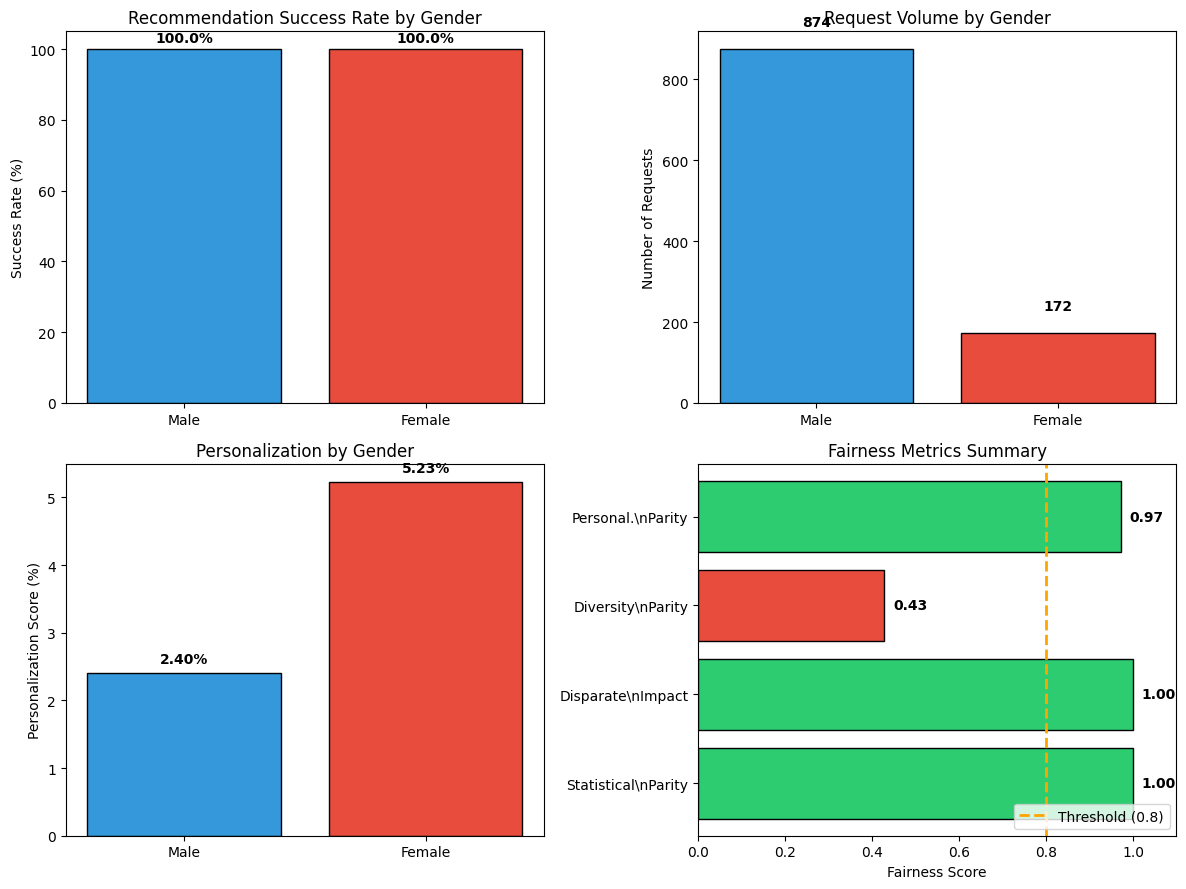

Charts saved to fairness_analysis_charts.png


In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# 1. Success Rate by Gender
ax1 = axes[0, 0]
genders = ['Male', 'Female']
success_rates = [male_success_rate, female_success_rate]
colors = ['#3498db', '#e74c3c']
bars = ax1.bar(genders, success_rates, color=colors, edgecolor='black')
ax1.set_ylabel('Success Rate (%)')
ax1.set_title('Recommendation Success Rate by Gender')
ax1.set_ylim(0, 105)
for bar, rate in zip(bars, success_rates):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{rate:.1f}%', 
             ha='center', va='bottom', fontweight='bold')

# 2. Request Volume by Gender
ax2 = axes[0, 1]
volumes = [total_male_recs, total_female_recs]
bars = ax2.bar(genders, volumes, color=colors, edgecolor='black')
ax2.set_ylabel('Number of Requests')
ax2.set_title('Request Volume by Gender')
for bar, vol in zip(bars, volumes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, f'{vol:,}', 
             ha='center', va='bottom', fontweight='bold')

# 3. Personalization Score by Gender
ax3 = axes[1, 0]
personalization_scores = [male_personalization, female_personalization]
bars = ax3.bar(genders, personalization_scores, color=colors, edgecolor='black')
ax3.set_ylabel('Personalization Score (%)')
ax3.set_title('Personalization by Gender')
for bar, score in zip(bars, personalization_scores):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{score:.2f}%', 
             ha='center', va='bottom', fontweight='bold')

# 4. Fairness Metrics Summary
ax4 = axes[1, 1]
metrics = ['Statistical\\nParity', 'Disparate\\nImpact', 'Diversity\\nParity', 'Personal.\\nParity']
values = [1 - abs(spd), dir_ratio, diversity_ratio, 1 - personalization_diff/100]
threshold = 0.8
colors_bar = ['#2ecc71' if v >= threshold else '#e74c3c' for v in values]
bars = ax4.barh(metrics, values, color=colors_bar, edgecolor='black')
ax4.axvline(x=threshold, color='orange', linestyle='--', linewidth=2, label='Threshold (0.8)')
ax4.set_xlim(0, 1.1)
ax4.set_xlabel('Fairness Score')
ax4.set_title('Fairness Metrics Summary')
ax4.legend(loc='lower right')
for bar, val in zip(bars, values):
    ax4.text(min(val + 0.02, 1.05), bar.get_y() + bar.get_height()/2, f'{val:.2f}', 
             ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('fairness_analysis_charts.png', dpi=150, bbox_inches='tight')
plt.show()
print("Charts saved to fairness_analysis_charts.png")

## 10. Cleanup

In [18]:
# Stop Spark session (uncomment if needed)
# spark.stop()
# print("Spark session stopped")